<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/UAPH4582/PH482_582_Sp22/blob/main/Hackathons/Hackathon-01.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

**This is an example Notebook for running training on Higgs vs background signal classification. **

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries. 

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this challenge, we focus on the potential of Machine Learning in detecting potential Higgs signal from one of the background processes that mimics it. 

**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine. 
The dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS)

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.




**Steps to load the training dataset**
1. Download the dataset from the UCI website. 

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2022-02-15 16:50:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2,6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2,62G  3,61MB/s    in 12m 24s 

2022-02-15 17:02:35 (3,61 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



2. Unzip the dataset folder

In [2]:
 !gzip -d HIGGS.csv.gz

In [1]:
pip install plot-metric ## For plotting ROC at the end

Note: you may need to restart the kernel to use updated packages.


In [1]:
## Scikit learn imports
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1337)  # for reproducibility
import h5py

## tensorflow/keras imports
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau


**Load the file using pandas library**

In [4]:
data=pd.read_csv('./HIGGS.csv')

Assign first column 0 to class labels (labeled 1 for signal, 0 for background)  and all others to feature matrix X.

For demonstration, here we only use 1000 samples. To train on the entire dataset, uncomment the lines below. 

In [6]:
X=data.iloc[:1000,1:]#data.iloc[:,1:]
y=data.iloc[:1000,0]#data.iloc[:,0]

Split your data into training and validation samples, where the fraction of the data used for validation is 20%. 

In [11]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [14]:
# 640 for training
# 160 for validation
# 200 for testing

**Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al 

In [18]:
#lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi,
#jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, 
#jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag,
#m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb

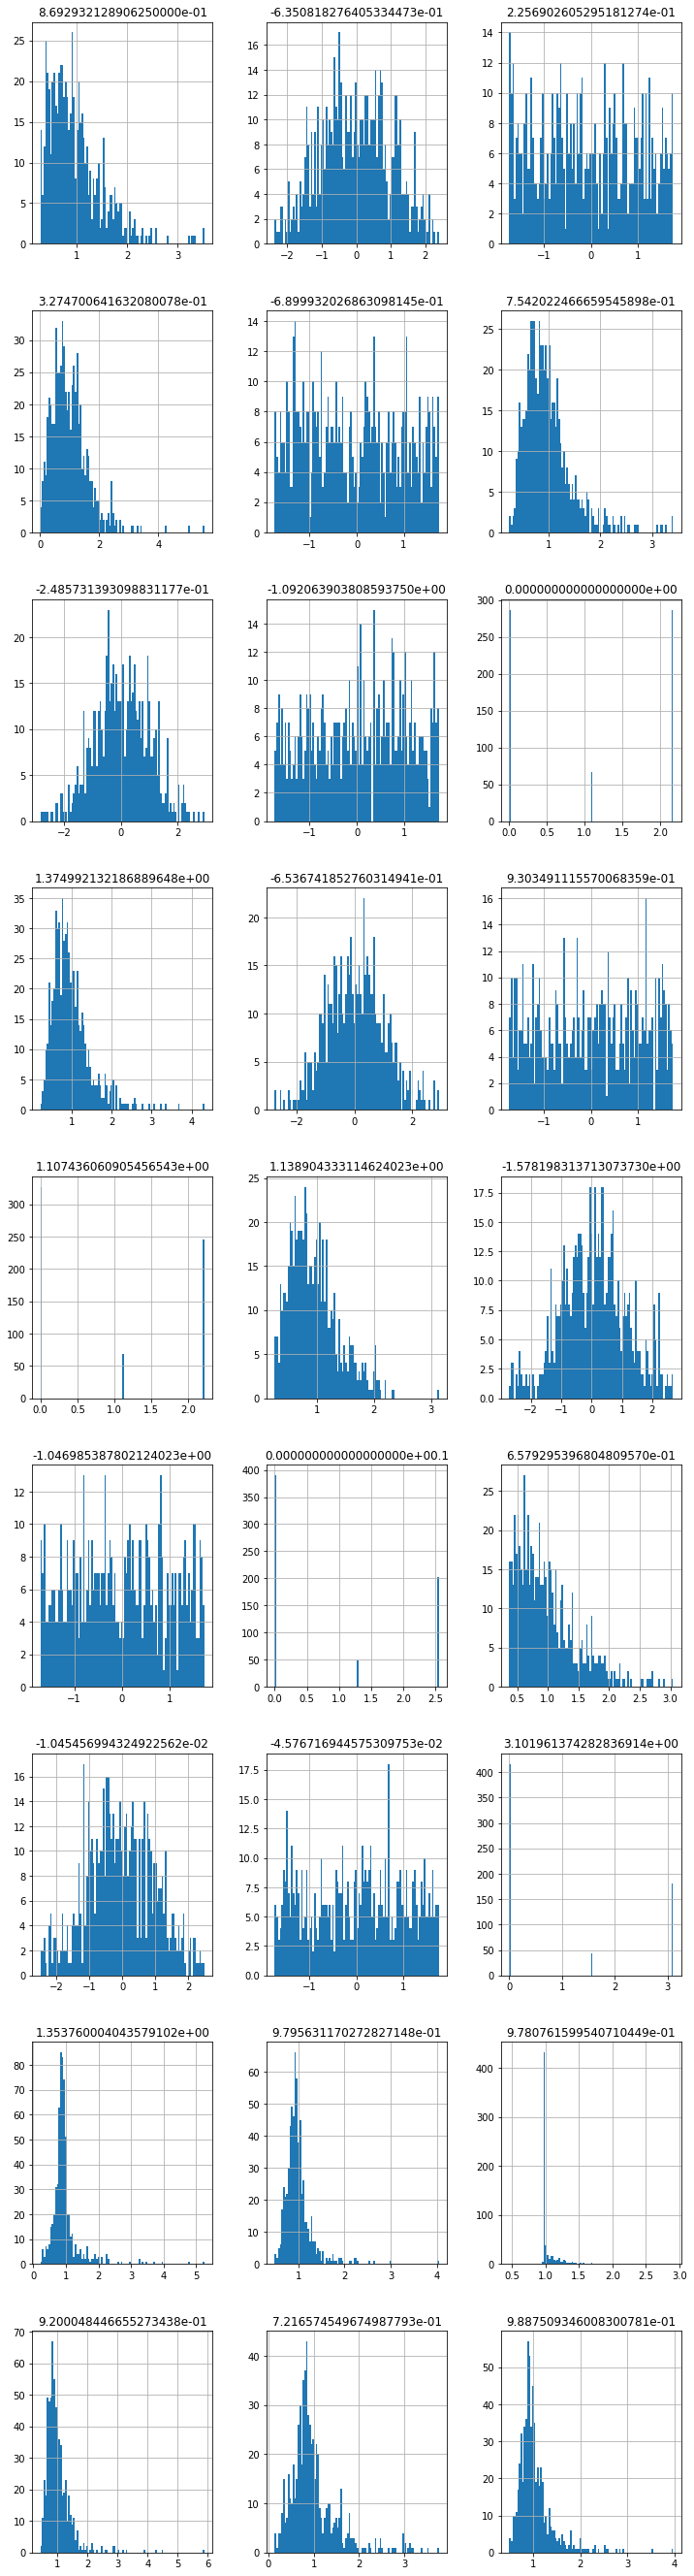

In [15]:
from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(X_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X_train.hist(column = X_train.columns[i], bins = 100, ax=axis)
        i = i+1

# Boosted Decision Tree model

**Setup the Boosted Decision Tree model** 


In [163]:
list_depth = [1,5,10,100]
list_estimators = [200, 1000, 5000, 10000]

dict_classifiers = {}


for depth,estimator in zip(list_depth,list_estimators):
    dict_classifiers[depth,estimator] = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=depth),
    n_estimators=estimator)

In [100]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200)

**Train the Boosted Decision Tree model**

In [101]:
classifier.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

**Predict on new testing data**

In [102]:
predictions = classifier.predict(X_test)

In [103]:
y_hat = classifier.predict_proba(X_test)[:, 1]

Print confusion matrix and plot ROC curve.

In [104]:
confusion_matrix(y_test, predictions)

array([[49, 43],
       [28, 80]])

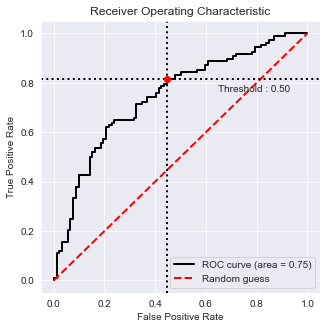

In [90]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_hat, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Shallow Neural Networks (optional for those who are familiar with NNs)

**Setup the Neural Network** (some useful info [here](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc))

In [152]:
# Keras NN
model_nn = Sequential()
model_nn.add(Dense(28, input_dim=28, activation='relu'))  # input layer
model_nn.add(Dense(8, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))              # output layer

In [153]:
#model_nn = Sequential()
#model_nn.add(Dense(28, input_dim=28, activation='relu'))
#model_nn.add(Dense(14, activation='relu'))
#model_nn.add(Dense(7, activation='relu'))
#model_nn.add(Dense(3, activation='relu'))
#model_nn.add(Dense(1, activation='sigmoid'))

**Train the Neural Network and save your model weights in a h5 file**

(Train for more epochs than shown here and play around with the architecture) 

In [154]:
# compile the keras model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
history=model_nn.fit(X, y,validation_data=(X_val,y_val),epochs=10, batch_size=5)
# evaluate the keras model
_, accuracy = model_nn.evaluate(X, y)
model_nn.save('my_model.h5') ##Saving model weights
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7002 - accuracy: 0.5270 - val_loss: 0.6880 - val_accuracy: 0.6187
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.5800 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6703 - accuracy: 0.5950 - val_loss: 0.6589 - val_accuracy: 0.6438
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6220 - val_loss: 0.6540 - val_accuracy: 0.6438
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6485 - accuracy: 0.6470 - val_loss: 0.6407 - val_accuracy: 0.6812
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.6650 - val_loss: 0.6403 - val_accuracy: 0.6375
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6240 - accuracy: 0.6640 - val_loss: 0.6198 - val_accuracy: 0.6875
Epoch 

In [122]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Plot accuracy wrt number of epochs**

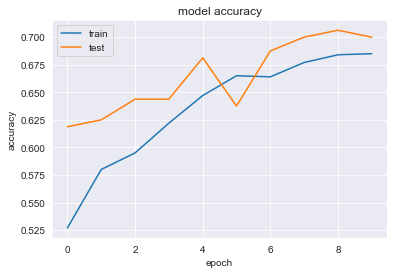

In [155]:

# summarize history for accuracy
plt.plot(history.history['accuracy'], )
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Plot training loss wrt number of epochs**

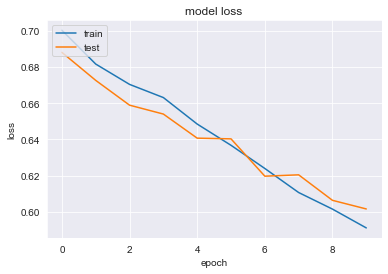

In [156]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [157]:
y_pred=model_nn.predict(X_test)

In [158]:
confusion_matrix(y_test, y_pred.round())

array([[46, 46],
       [13, 95]])

**Plot the ROC (Receiver Operating Characteristic) Curve** (more info on ROC could be found [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

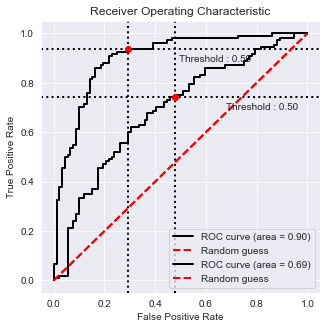

In [151]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])
bc_bdt = BinaryClassification(y_test, y_hat, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
bc_bdt.plot_roc_curve()

plt.show()

**Goal:** Please train your own machine learning model (or modify provided examples) with the goal of attaining the top classifier performance.

**Deliverables:**

Please submit the following:

- Your full notebook (pdf and `.ipynb`) used for training including the ROC Curves, loss and accuracy plots wrt number of epochs.
- for Neural Networks: model weights (`.h5`)

**References:**

Baldi, P., Sadowski P., and Whiteson D. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).